# ECE 225 Final Project - Music Chrod Progression Analysis

In [1]:
# Import packages
%matplotlib inline
import os.path
import json
import glob
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
from matplotlib.ticker import FormatStrFormatter

In [2]:
# Set Matplotlib default style
plt.rc('figure', titleweight='bold', dpi=100)
plt.rc('axes', labelweight='bold',  linewidth=1.5, titleweight='bold')
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')

## Data preprocessing

In [3]:
# Download and decompress dataset
if not os.path.exists("data/event"):
    exec("wget -P data https://github.com/salu133445/music_chord_progression/raw/master/event.tar.gz")
    exec("tar zxf data/event.tar.gz -C data/")

In [4]:
# Constant
note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

In [5]:
# Load data
data, info = [], []
for filepath in glob.glob("data/event/*/*/*/*_symbol_nokey.json"):
    with open(filepath) as f:
        data.append(json.load(f))
    with open("data/xml" + os.path.split(filepath[10:])[0] + "/song_info.json") as f:
        info.append(json.load(f))

## Metadata analysis

In [6]:
keys = []
bpms = []
beats_in_measures = []
for song in data:
    keys.append(song['metadata']['key'])
    bpms.append(int(song['metadata']['BPM']))
    beats_in_measures.append(song['metadata']['beats_in_measure'])
count_keys = Counter(keys).most_common()
count_bpms = Counter(bpms).most_common()
count_beats_in_measures = Counter(beats_in_measures).most_common()

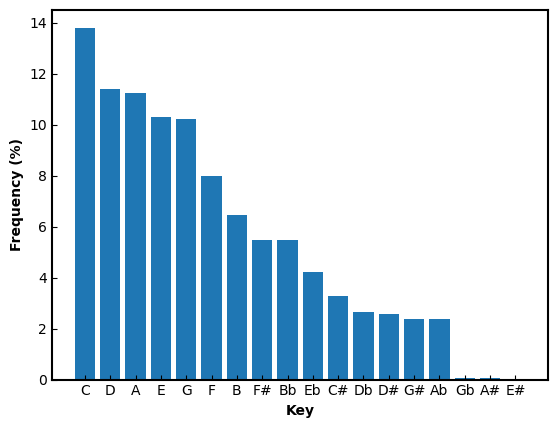

In [7]:
# Keys count
plt.bar(range(len(count_keys)), [x[1] * 100 / len(data) for x in count_keys])
labels = [x[0] for x in count_keys]
plt.xticks(range(len(count_keys)), labels=labels)
plt.xlabel('Key')
plt.ylabel('Frequency (%)')
plt.show()

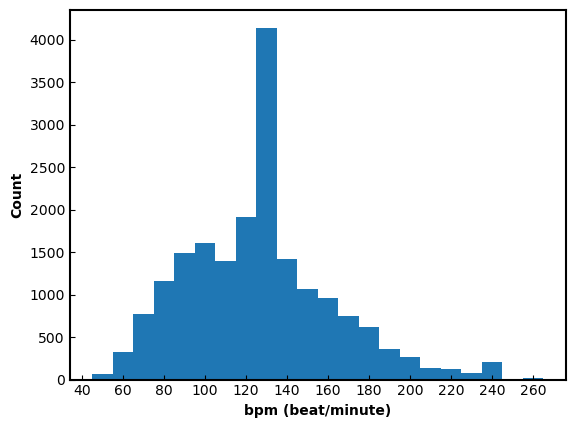

In [8]:
# BPM count
plt.hist(bpms, np.arange(45,275,10))
plt.xticks(np.arange(40,280,20))
plt.xlabel('bpm (beat/minute)')
plt.ylabel('Count')
plt.show()

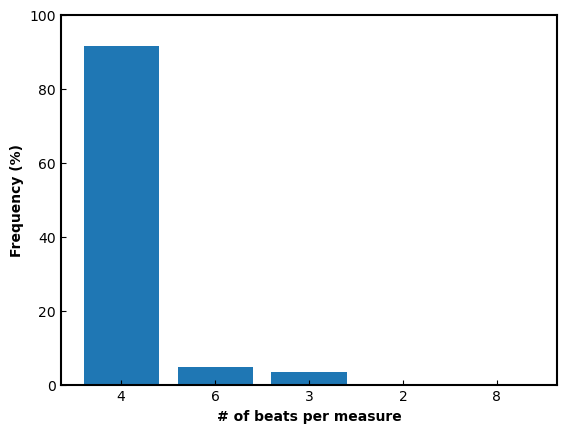

In [9]:
# Beats per measure count
plt.bar(range(len(count_beats_in_measures)), [x[1] * 100 / len(data) for x in count_beats_in_measures])
labels = [x[0] for x in count_beats_in_measures]
plt.xticks(range(len(count_beats_in_measures)), labels=labels)
plt.xlabel('# of beats per measure')
plt.ylabel('Frequency (%)')
plt.ylim(0, 100)
plt.show()

## Chord-level analysis

In [10]:
# Chord sequence without repeatness (e.g., CCFFGG -> CFG)
chord_sequences = []
song_infos = []
for song, song_info in zip(data, info):
    c = [x for x in song['tracks']['chord'] if x is not None]
    if not c:
        continue
    prev = c[0]
    chord_sequence = [prev]
    for now in c:
        if (prev['root'] == now['root']) and (prev['quality'] == now['quality']):
            continue
        chord_sequence.append(now)
        prev = now
    chord_sequences.append(chord_sequence)
    song_infos.append(song_info)

In [11]:
qualities = []
chords = []
for chord_sequence in chord_sequences:
    for c in chord_sequence:
        qualities.append(c['quality'])
        chords.append(note_names[c['root']] + c['quality'])
n_chords = len(chords)
count_qualities = Counter(qualities).most_common()
count_chords = Counter(chords).most_common()

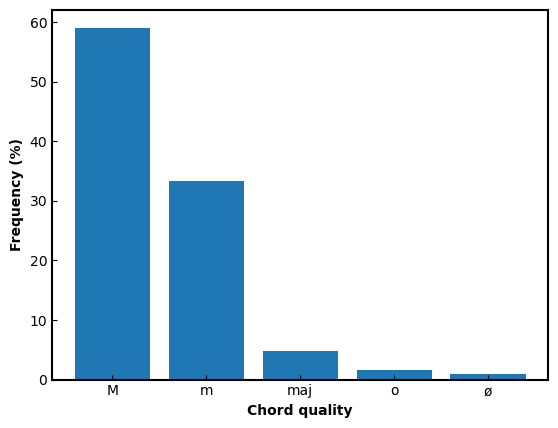

In [12]:
# Chord quailty count
plt.bar(range(len(count_qualities)), [x[1] * 100 / n_chords for x in count_qualities])
labels = [x[0] for x in count_qualities]
labels[0] = 'M'
plt.xticks(range(len(count_qualities)), labels=labels)
plt.xlabel('Chord quality')
plt.ylabel('Frequency (%)')
plt.show()

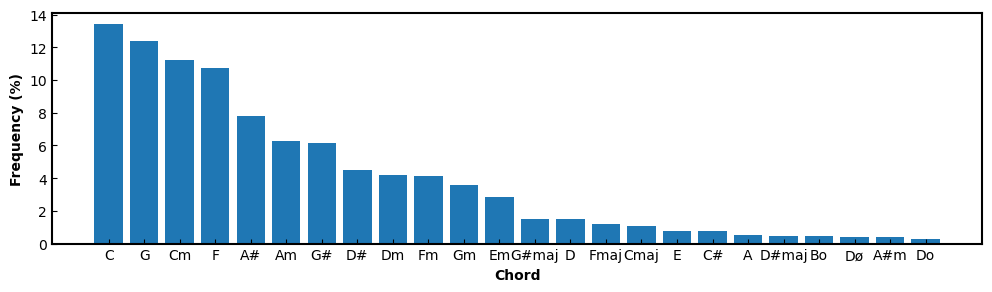

In [13]:
# Chord count
count_chords_ = count_chords[:24]
plt.figure(figsize=(12, 3))
plt.bar(range(len(count_chords_)), [x[1] * 100 / n_chords for x in count_chords_])
plt.xticks(range(len(count_chords_)), labels=[x[0] for x in count_chords_])
plt.xlabel('Chord')
plt.ylabel('Frequency (%)')
plt.show()

In [14]:
chord_transitions = []
chord_transition_pairs = np.zeros((15, 15))
top_chords = [x[0] for x in count_chords_[:15]]
for chord_sequence in chord_sequences:
    for prev, now in zip(chord_sequence[:-1], chord_sequence[1:]):
        prev_chord = note_names[prev['root']] + prev['quality']
        now_chord = note_names[now['root']] + now['quality']
        chord_transitions.append(
            note_names[prev['root']] + prev['quality'] + '-' + note_names[now['root']] + now['quality'])
        if prev_chord in top_chords and now_chord in top_chords:
            chord_transition_pairs[top_chords.index(prev_chord), top_chords.index(now_chord)] += 1
n_chord_transitions = len(chord_transitions)
count_chord_transitions = Counter(chord_transitions).most_common()

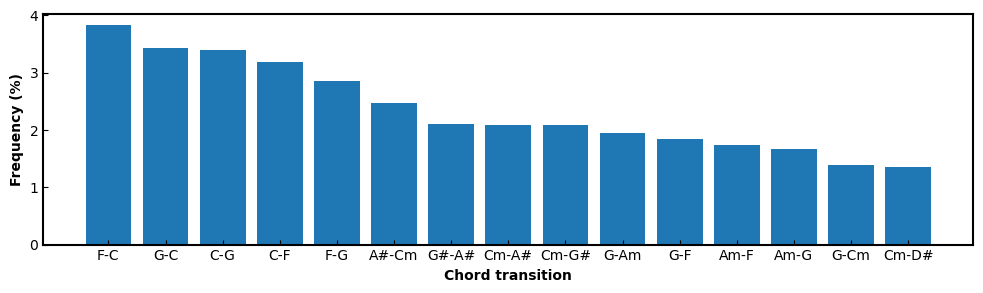

In [15]:
# Chord transition count
count_chord_transitions_ = count_chord_transitions[:15]
plt.figure(figsize=(12, 3))
plt.bar(range(len(count_chord_transitions_)), [x[1] * 100 / n_chord_transitions for x in count_chord_transitions_])
plt.xticks(range(len(count_chord_transitions_)), labels=[x[0] for x in count_chord_transitions_])
plt.xlabel('Chord transition')
plt.ylabel('Frequency (%)')
plt.show()

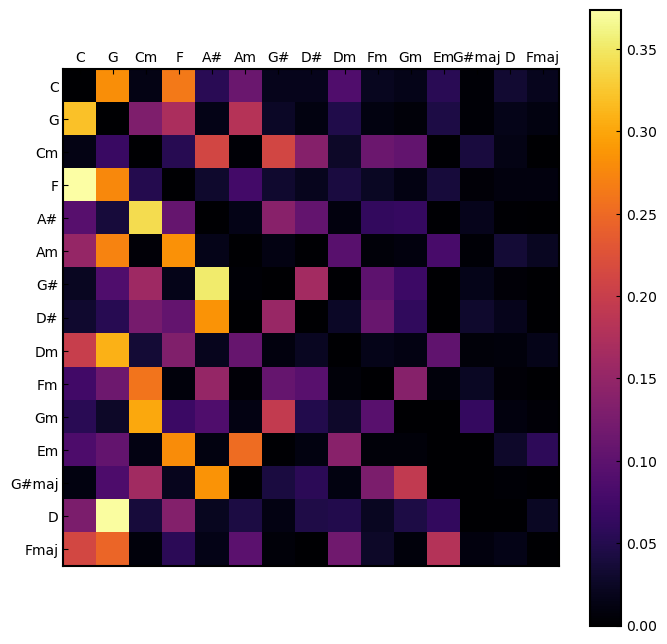

In [17]:
plt.figure(figsize=(8, 8))
plt.imshow(chord_transition_pairs / chord_transition_pairs.sum(axis=1, keepdims=True), cmap='inferno')
plt.xticks(range(len(top_chords)), labels=top_chords)
plt.yticks(range(len(top_chords)), labels=top_chords)
plt.gca().xaxis.tick_top()
plt.colorbar()
plt.show()

In [20]:
chord_transition_pairs[1] / chord_transition_pairs.sum(axis=1, keepdims=True)[1]

array([0.32110132, 0.        , 0.13046514, 0.17191727, 0.01544637,
       0.18151671, 0.02556942, 0.01034122, 0.04817174, 0.01082119,
       0.00689414, 0.04524828, 0.00431975, 0.01662449, 0.01156296])

In [17]:
three_grams = []
for chord_sequence in chord_sequences:
    for prev, now, nex in zip(chord_sequence[:-2], chord_sequence[1:-1], chord_sequence[2:]):
        three_grams.append(
            note_names[prev['root']] + prev['quality'] + '-' + note_names[now['root']] + now['quality']
            + '-' + note_names[nex['root']] + nex['quality'])
n_three_grams = len(chord_transitions)
count_three_grams = Counter(three_grams).most_common()

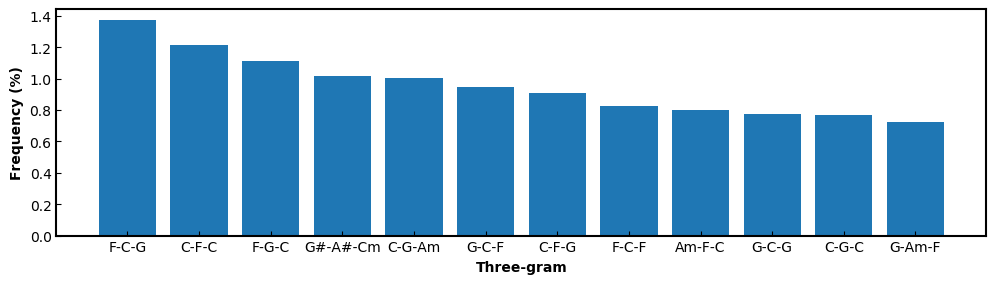

In [18]:
# Chord three-gram count
count_three_grams_ = count_three_grams[:12]
plt.figure(figsize=(12, 3))
plt.bar(range(len(count_three_grams_)), [x[1] * 100 / n_chord_transitions for x in count_three_grams_])
plt.xticks(range(len(count_three_grams_)), labels=[x[0] for x in count_three_grams_])
plt.xlabel('Three-gram')
plt.ylabel('Frequency (%)')
plt.show()

In [19]:
four_grams = []
for chord_sequence in chord_sequences:
    for prev, now, nex, nnex in zip(chord_sequence[:-3], chord_sequence[1:-2], chord_sequence[2:-1], chord_sequence[3:]):
        if (prev['root'] == nex['root']) and (prev['quality'] == nex['quality']):
            continue
        if (now['root'] == nnex['root']) and (now['quality'] == nnex['quality']):
            continue
        four_grams.append(
            note_names[prev['root']] + prev['quality']
            + '-' + note_names[now['root']] + now['quality']
            + '-' + note_names[nex['root']] + nex['quality']
            + '-' + note_names[nnex['root']] + nnex['quality'])
n_four_grams = len(chord_transitions)
count_four_grams = Counter(four_grams).most_common()

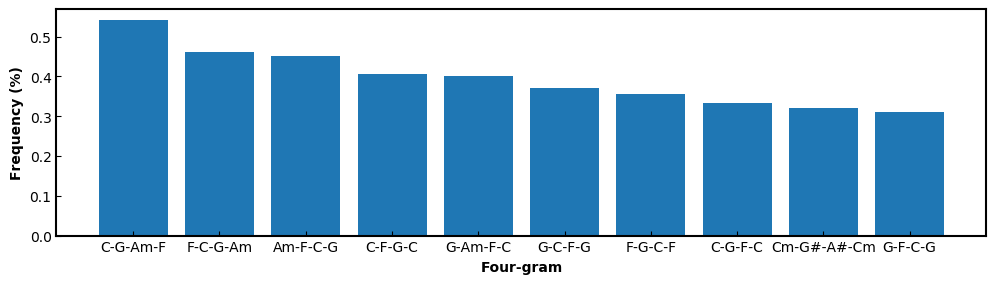

In [20]:
# Chord four-gram count
count_four_grams_ = count_four_grams[:10]
plt.figure(figsize=(12, 3))
plt.bar(range(len(count_four_grams_)), [x[1] * 100 / n_chord_transitions for x in count_four_grams_])
plt.xticks(range(len(count_four_grams_)), labels=[x[0] for x in count_four_grams_])
plt.xlabel('Four-gram')
plt.ylabel('Frequency (%)')
plt.show()

## Genre Analysis

In [21]:
all_genres = []
for x in info:
    if x['genres']:
        all_genres.extend(x['genres'])
count_genres = Counter(all_genres).most_common()
n_count_genres = len(all_genres)
top_genres = [x[0] for x in count_genres[:9]]

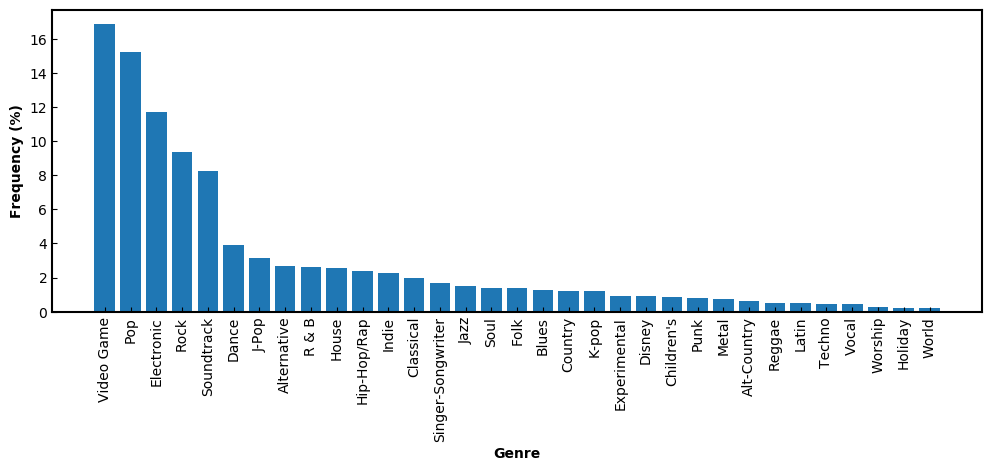

In [22]:
# Genre count
plt.figure(figsize=(12, 4))
plt.bar(range(len(count_genres)), [x[1] * 100 / n_count_genres for x in count_genres])
plt.xticks(range(len(count_genres)), labels=[x[0] for x in count_genres], rotation=90)
plt.xlabel('Genre')
plt.ylabel('Frequency (%)')
plt.show()

In [23]:
genre_chords = [[] for _ in range(len(top_genres))]
for (chord_sequence, song_info) in zip(chord_sequences, song_infos):
    if song_info['genres']:
        for g in song_info['genres']:
            if g not in top_genres:
                continue
            for c in chord_sequence:
                genre_chords[top_genres.index(g)].append(note_names[c['root']] + c['quality'])
n_genre_chords = [len(genre_chord) for genre_chord in genre_chords]
count_genre_chords = [Counter(genre_chord).most_common() for genre_chord in genre_chords]

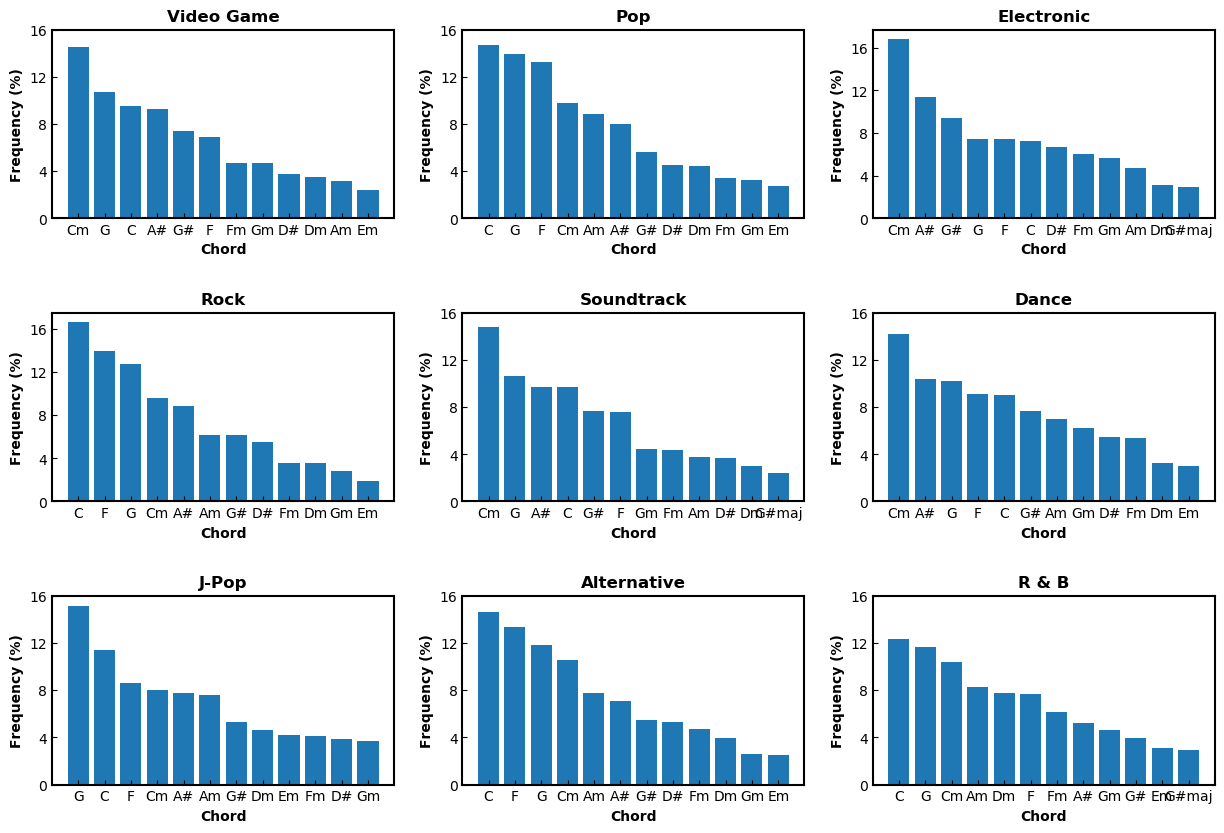

In [24]:
# Chord count per genre
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)
for idx, (genre, count_genre_chord, n_genre_chord) in enumerate(zip(top_genres, count_genre_chords, n_genre_chords)):
    plt.subplot(3, 3, idx + 1)
    count_genre_chord_ = count_genre_chord[:12]
    plt.bar(range(len(count_genre_chord_)), [x[1] * 100 / n_genre_chord for x in count_genre_chord_])
    plt.xticks(range(len(count_genre_chord_)), labels=[x[0] for x in count_genre_chord_])
    plt.yticks(np.arange(0, 17, 4))
    plt.xlabel('Chord')
    plt.ylabel('Frequency (%)')
    plt.title(genre)
plt.show()

In [25]:
genre_chord_transitions = [np.zeros((10, 10)) for _ in range(len(top_genres))]
top_chords = [x[0] for x in count_chords[:10]]
for (chord_sequence, song_info) in zip(chord_sequences, song_infos):
    if song_info['genres']:
        for g in song_info['genres']:
            if g not in top_genres:
                continue
            for prev, now in zip(chord_sequence[:-1], chord_sequence[1:]):
                prev_chord = note_names[prev['root']] + prev['quality']
                now_chord = note_names[now['root']] + now['quality']
                if prev_chord in top_chords and now_chord in top_chords:
                    genre_chord_transitions[top_genres.index(g)][top_chords.index(prev_chord), top_chords.index(now_chord)] += 1

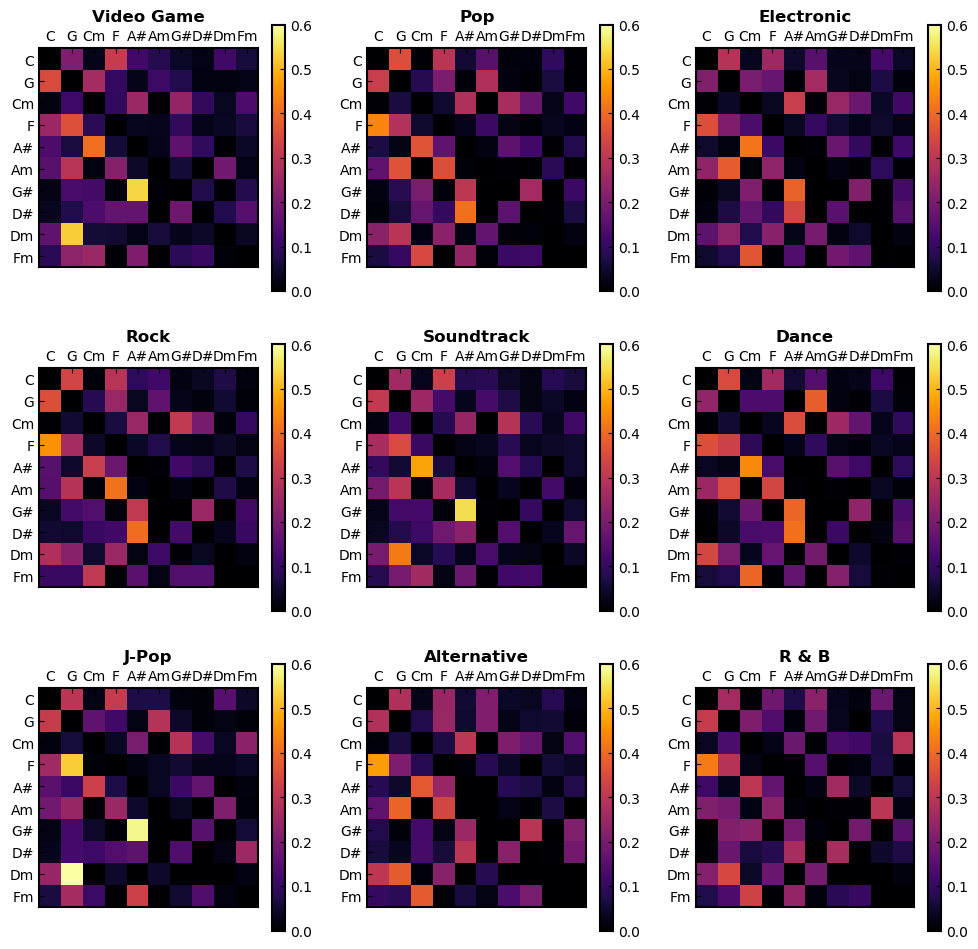

In [26]:
# Chord transition per genre
plt.figure(figsize=(12, 12))
for idx, (genre, genre_chord_transition) in enumerate(zip(top_genres, genre_chord_transitions)):
    plt.subplot(3, 3, idx + 1)
    plt.imshow(genre_chord_transition / genre_chord_transition.sum(axis=1, keepdims=True), cmap='inferno', vmin=0, vmax=0.6)
    plt.title(genre)
    plt.xticks(range(len(top_chords)), labels=top_chords)
    plt.yticks(range(len(top_chords)), labels=top_chords)
    plt.gca().xaxis.tick_top()
    plt.colorbar()
plt.show()